In [1]:
import os
import pdb
import h5py
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr

In [2]:
PREDS_PATH = "/global/scratch/users/aniketh/finetune-enformer/test_preds/joint_training_classification_trial_A40x4_h5_dataset_fix_sign/"
GEUVADIS_COUNTS_PATH = "../process_geuvadis_data/tpm/tpm_pca_annot.csv.gz"
BASELINE_PREDS_PATH = (
    "../process_geuvadis_data/enformer_sample_preds.csv"
)
test_h5 = "/clusterfs/nilah/ruchir/src/finetuning-enformer/finetuning/data/h5_bins_384_chrom_split/test.h5"
test_h5 = h5py.File(test_h5, "r")

In [3]:
def load_geuvadis_data() -> pd.DataFrame:
    counts_df = pd.read_csv(GEUVADIS_COUNTS_PATH, index_col=0)
    counts_df = counts_df.reset_index().set_index("our_gene_name")
    return counts_df

In [4]:
def load_finetuned_preds():
    """
    Returns a dictionary of dictionaries, where the outer keys are the genes
    and the inner keys are the samples. The values are the predictions.
    """
    preds_by_gene = defaultdict(dict)
    ancestries_by_gene = defaultdict(dict)
    data = np.load(os.path.join(PREDS_PATH, "test_preds.npz"))

    preds, genes, samples = data["preds"], data["genes"], data["samples"]
    ancestries = test_h5["ancestries"][:].astype(str)
    for (pred, gene, sample, ancestry) in zip(preds, genes, samples, ancestries):
        preds_by_gene[gene][sample] = pred
        ancestries_by_gene[gene][sample] = ancestry
    return preds_by_gene, ancestries_by_gene


def get_finetuned_corrs(finetuned_preds, geuvadis_df):
    corrs = {}
    for g in finetuned_preds:
        assert g in geuvadis_df.index
        samples = list(finetuned_preds[g].keys())
        gene_preds = [finetuned_preds[g][s] for s in samples]
        gene_counts = geuvadis_df.loc[g, samples].values.astype("float32")
        assert np.isnan(gene_preds).sum() == 0
        assert np.isnan(gene_counts).sum() == 0
        corrs[g] = spearmanr(gene_preds, gene_counts)[0]
        
        try:
            assert np.isnan(corrs[g]).sum() == 0
        except:
            print(f"Gene {g} has invalid predictions/counts and thus has a nan spearmanR")
            
    return corrs


def compare_to_geuvadis_counts(finetuned_preds, geuvadis_df, gene, ax):
    samples = list(finetuned_preds[gene].keys())
    gene_preds = [finetuned_preds[gene][s] for s in samples]
    gene_counts = geuvadis_df.loc[gene, samples].values
    ax.scatter(gene_counts, gene_preds)
    ax.set(
        xlabel="Geuvadis counts",
        ylabel="finetuned predictions",
        title=f"Correlation: {spearmanr(gene_preds, gene_counts)[0]:.3f}",
    )


def compare_to_baseline_counts(finetuned_preds, baseline_df, gene, ax):
    samples = list(finetuned_preds[gene].keys())
    baseline_preds = baseline_df[gene][samples].values
    finetuned_preds = [finetuned_preds[gene][s] for s in samples]
    ax.scatter(baseline_preds, finetuned_preds)
    ax.set(
        xlabel="baseline predictions",
        ylabel="finetuned predictions",
        title=f"Correlation: {spearmanr(baseline_preds, finetuned_preds)[0]:.3f}",
    )

In [5]:
def load_other_model_preds_df(preds_df_path):
    preds_df = pd.read_csv(preds_df_path, index_col=0)
    return preds_df


def get_other_model_corrs(preds_df, geuvadis_df, finetuned_preds):
    corrs = {}
    for g in finetuned_preds:
        assert g in preds_df.columns
        assert g in geuvadis_df.index
        samples = list(finetuned_preds[g].keys())

        gene_preds = preds_df[g][samples].values
        gene_counts = geuvadis_df.loc[g, samples].values
        corrs[g] = spearmanr(gene_preds, gene_counts)[0]
        
        try:
            assert np.isnan(corrs[g]).sum() == 0
        except:
            print(f"Gene {g} has invalid predictions/counts and thus has a nan spearmanR")
            
    return corrs

In [6]:
geuvadis_df = load_geuvadis_data()

In [7]:
finetuned_preds, ancestries_by_gene = load_finetuned_preds()
finetuned_corrs = get_finetuned_corrs(finetuned_preds, geuvadis_df)

Gene golga6l9 has invalid predictions/counts and thus has a nan spearmanR


/clusterfs/nilah/aniketh/mamba_envs/promoter_models/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [8]:
baseline_df = load_other_model_preds_df(BASELINE_PREDS_PATH)
baseline_corrs = get_other_model_corrs(baseline_df, geuvadis_df, finetuned_preds)

In [9]:
def compare_finetuned_to_baseline_perf(
    finetuned_corrs, baseline_corrs, finetuned_preds, ancestries_by_gene, abs_corrs: bool = False
):
    genes = list(finetuned_corrs.keys())
    finetuned_corrs_l = [finetuned_corrs[g] for g in genes]
    baseline_corrs_l = [baseline_corrs[g] for g in genes]
    
    gene_class = []
    for g in genes:
        temp = np.array([ancestries_by_gene[g][key] for key in ancestries_by_gene[g]])
        if (temp != "Yoruba").sum() == 0:
            gene_class.append("yri_split")
        elif len(finetuned_preds[g]) <= 77:
            gene_class.append("random_split")
        else:
            gene_class.append("unseen")
    
    df = pd.DataFrame(
        {
            "gene": genes,
            "finetuned Spearman": np.abs(finetuned_corrs_l) 
            if abs_corrs 
            else finetuned_corrs_l,
            "baseline Spearman": np.abs(baseline_corrs_l)
            if abs_corrs
            else baseline_corrs_l,
            "gene_class": gene_class,
        }
    )

    ax = sns.scatterplot(
        data=df,
        x="baseline Spearman",
        y="finetuned Spearman",
        hue="gene_class",
    )
    ax.set_ylabel("|finetuned Spearman|" if abs_corrs else "finetuned Spearman")
    ax.set_xlabel("|baseline Spearman|" if abs_corrs else "baseline Spearman")
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.set(aspect="equal", xlim=lims, ylim=lims)
    
    ax.axhline(
        df[df["gene_class"] == "random_split"]["finetuned Spearman"].mean(),
        color="blue",
        ls="--",
        label="random_split"
    )
    ax.axvline(
        df[df["gene_class"] == "random_split"]["baseline Spearman"].mean(),
        color="blue",
        ls="--",
        label="random_split"
    )

    ax.axhline(
        df[df["gene_class"] == "yri_split"]["finetuned Spearman"].mean(),
        color="orange",
        ls="--",
        label="yri_split"
    )
    ax.axvline(
        df[df["gene_class"] == "yri_split"]["baseline Spearman"].mean(),
        color="orange",
        ls="--",
        label="yri_split"
    )
    
    ax.axhline(
        df[df["gene_class"] == "unseen"]["finetuned Spearman"].mean(),
        color="green",
        ls="--",
        label="unseen"
    )
    ax.axvline(
        df[df["gene_class"] == "unseen"]["baseline Spearman"].mean(),
        color="green",
        ls="--",
        label="unseen"
    )
    
    for split in ["random_split", "yri_split", "unseen"]:
        print(f"Split {split}, n_samples = {(df['gene_class'] == split).sum()}")
        print(f"Baseline SpearmanR = {df[df['gene_class'] == split]['baseline Spearman'].mean()}")
        print(f"Finetuned SpearmanR = {df[df['gene_class'] == split]['finetuned Spearman'].mean()}")
        print()

    plt.show()
    return df

Split random_split, n_samples = 200
Baseline SpearmanR = 0.047489568453779746
Finetuned SpearmanR = 0.21788813710615185

Split yri_split, n_samples = 200
Baseline SpearmanR = 0.04391560739411288
Finetuned SpearmanR = 0.1583600203042953

Split unseen, n_samples = 100
Baseline SpearmanR = 0.03932086254924582
Finetuned SpearmanR = 0.04734914446039531



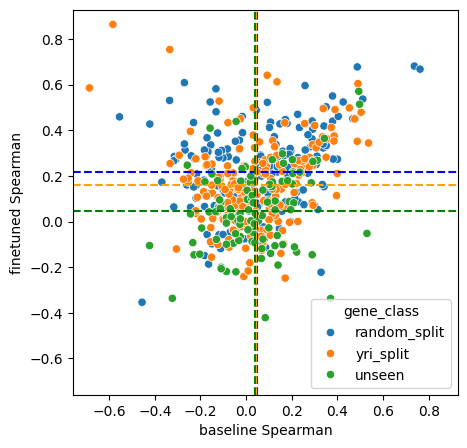

In [10]:
fig, axs = plt.subplots(ncols=1, figsize=(10, 5))
_ = compare_finetuned_to_baseline_perf(
    finetuned_corrs, baseline_corrs, finetuned_preds, ancestries_by_gene
)
plt.show()

Split random_split, n_samples = 200
Baseline SpearmanR = 0.17275615608718337
Finetuned SpearmanR = 0.23614703984530244

Split yri_split, n_samples = 200
Baseline SpearmanR = 0.14847005973715366
Finetuned SpearmanR = 0.18618196934005485

Split unseen, n_samples = 100
Baseline SpearmanR = 0.13361915746223896
Finetuned SpearmanR = 0.14185145157158582



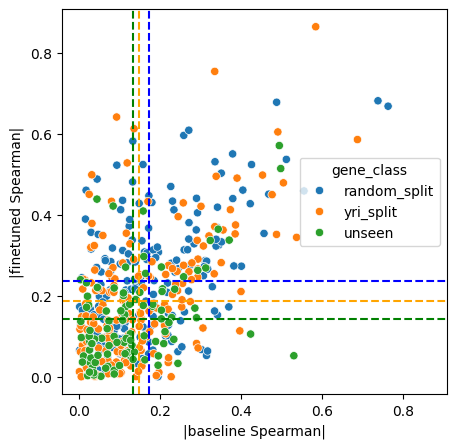

In [11]:
fig, axs = plt.subplots(ncols=1, figsize=(10, 5))
_ = compare_finetuned_to_baseline_perf(
    finetuned_corrs, baseline_corrs, finetuned_preds, ancestries_by_gene, abs_corrs=True
)
plt.show()